In [1301]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cvxopt import solvers
from cvxopt import matrix

In [1377]:
rand = np.random.RandomState(123)

sample_size = 250
c0 = rand.normal(4, 2, (sample_size, 2))
c1 = rand.normal(10, 2, (sample_size, 2))
c0_l = np.full(sample_size, -1)
c1_l = np.ones(sample_size)

# data
X = np.concatenate((c0, c1))
T = np.concatenate((c0_l, c1_l))

# shuffle data
shuffle_mask = np.arange(len(X))
rand.shuffle(shuffle_mask)

X = X[shuffle_mask]
T = T[shuffle_mask]

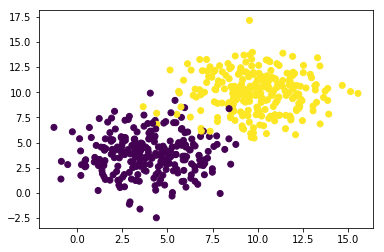

In [1378]:
plt.scatter(X[:, 0], X[:, 1], c=T);

In [1379]:
from sklearn.model_selection import train_test_split

# split data
X_train, x_travel, X_test, t_travel = train_test_split(X, T, test_size=0.3, random_state=12)
t_train, v_train, t_test, v_test = train_test_split(x_travel, t_travel, test_size=0.5, random_state=13)

In [1380]:
# define kernel
def kernel(x, x_):
    return x.T.dot(x_)

In [1381]:
class SVM:
    
    def __init__(self, kernel, c):
        self.kernel = karnel
        self.c = c
    
    def train(self, X, T, minimal_support_vector_multiplier=0.05):
        # find multipliers - a
        a = self.__find_multipliers(X, T, minimal_support_vector_multiplier)
        
        indices = a > minimal_support_vector_multiplier
        
        self.a = a[indices]
        self.supp_vec = X[indices]
        self.supp_vec_t = T[indices]
        
        self.n_supp_vec = np.sum(indices == True)

        self.b = self.__find_b()
        
        return self
        
    def predict(self, x, include_b=True):
        b = self.b if include_b else 0
        return np.sign(sum([
            self.a[i] * self.supp_vec_t[i] * self.kernel(self.supp_vec[i], x) + b
            for i in range(self.n_supp_vec)
        ]))
    
    def predict_all(self, t_train):
        return np.array([self.predict(x) for x in t_train])
    
    def score(self, t_train, t_test):
        return np.sum(self.predict_all(t_train) == t_test) / len(t_train)
    
    def __find_b(self):
        return sum([
            self.supp_vec_t[n] - self.predict(self.supp_vec[n], include_b=False)
            for n in range(self.n_supp_vec)
        ]) / self.n_supp_vec
    
    def __find_multipliers(self, X, T, minimal_support_vector_multiplier):
        # prepare the parameters for solition
        length = len(X)
        q = matrix(np.full(length, -1, dtype=np.float64))
        P = matrix(np.array([
            t1*t2*self.kernel(x1, x2) for x1, t1 in zip(X, T) for x2, t2 in zip(X, T)]
        ).reshape(-1, length))
        A = matrix(T.reshape(-1, length))
        G = matrix(np.concatenate((np.eye(length) * -1, np.eye(length))))
        h = matrix(np.hstack((np.zeros(length), np.full(length, self.c))))
        b = matrix(0.0)
        
        sol = solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)
        return np.ravel(sol['x'])

In [1382]:
def find_best_model(X, T, C, folds=5):
    
    fold_size = len(X) // folds
    models_and_scores = []
    
    # cross validation
    for fold in range(folds):
        mask = np.ones(len(X), dtype=bool)
        mask[fold * fold_size: (fold + 1) * fold_size] = False
        
        x_train, t_train, x_test, t_test = X[mask], X[~mask], T[mask], T[~mask]
        
        models = [
            SVM(kernel, c).train(x_train, x_test, 0.1)
            for c in C
        ]
        
        models_and_scores.extend([(model, model.score(t_train, t_test)) for model in models])
    
    index = np.argmax(np.array(models_and_scores)[:, 1])
    return models_and_scores[index]

In [1383]:
C = [8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26]
best_model, best_score = find_best_model(X_train, X_test, C)

     pcost       dcost       gap    pres   dres
 0: -2.4595e+02 -1.2596e+04  4e+04  8e-01  1e-12
 1: -1.4929e+02 -3.2614e+03  5e+03  8e-02  9e-13
 2: -9.9270e+01 -6.4128e+02  8e+02  1e-02  7e-13
 3: -1.0409e+02 -2.7872e+02  2e+02  2e-03  6e-13
 4: -1.1106e+02 -2.0834e+02  1e+02  1e-03  7e-13
 5: -1.1954e+02 -1.6341e+02  5e+01  2e-04  6e-13
 6: -1.2389e+02 -1.6111e+02  4e+01  1e-04  7e-13
 7: -1.2229e+02 -1.5709e+02  4e+01  9e-05  6e-13
 8: -1.2659e+02 -1.5535e+02  3e+01  5e-05  7e-13
 9: -1.2587e+02 -1.5394e+02  3e+01  4e-05  6e-13
10: -1.2926e+02 -1.4731e+02  2e+01  2e-05  6e-13
11: -1.3103e+02 -1.4316e+02  1e+01  1e-05  7e-13
12: -1.3185e+02 -1.4165e+02  1e+01  5e-06  7e-13
13: -1.3421e+02 -1.3776e+02  4e+00  1e-07  8e-13
14: -1.3503e+02 -1.3669e+02  2e+00  2e-08  8e-13
15: -1.3568e+02 -1.3600e+02  3e-01  3e-09  8e-13
16: -1.3583e+02 -1.3584e+02  4e-03  4e-11  9e-13
17: -1.3584e+02 -1.3584e+02  4e-05  4e-13  9e-13
Optimal solution found.
     pcost       dcost       gap    pres   dre

     pcost       dcost       gap    pres   dres
 0: -7.2876e+02 -1.0825e+05  3e+05  7e-01  3e-12
 1: -3.9367e+02 -2.2661e+04  3e+04  6e-02  3e-12
 2: -2.6560e+02 -4.3166e+03  5e+03  7e-03  2e-12
 3: -2.9870e+02 -1.2087e+03  9e+02  5e-04  2e-12
 4: -3.2982e+02 -9.1254e+02  6e+02  2e-04  2e-12
 5: -3.4989e+02 -7.3248e+02  4e+02  4e-05  2e-12
 6: -3.4500e+02 -6.8261e+02  3e+02  2e-05  2e-12
 7: -3.7775e+02 -5.7210e+02  2e+02  1e-05  2e-12
 8: -4.0726e+02 -5.2562e+02  1e+02  3e-06  2e-12
 9: -4.0508e+02 -5.1410e+02  1e+02  2e-06  2e-12
10: -4.0792e+02 -5.0388e+02  1e+02  1e-06  2e-12
11: -4.1109e+02 -4.9789e+02  9e+01  1e-06  2e-12
12: -4.0996e+02 -4.9071e+02  8e+01  6e-07  2e-12
13: -4.1608e+02 -4.8126e+02  7e+01  4e-07  2e-12
14: -4.2711e+02 -4.6123e+02  3e+01  5e-08  3e-12
15: -4.3692e+02 -4.4500e+02  8e+00  2e-09  3e-12
16: -4.3910e+02 -4.4210e+02  3e+00  6e-10  3e-12
17: -4.4013e+02 -4.4085e+02  7e-01  1e-10  2e-12
18: -4.4043e+02 -4.4050e+02  7e-02  5e-12  3e-12
19: -4.4047e+02 -4.40

     pcost       dcost       gap    pres   dres
 0: -6.7823e+02 -9.0937e+04  2e+05  7e-01  3e-12
 1: -3.6908e+02 -1.9127e+04  3e+04  6e-02  2e-12
 2: -2.3922e+02 -3.4501e+03  4e+03  8e-03  2e-12
 3: -2.7002e+02 -1.4586e+03  1e+03  2e-03  1e-12
 4: -3.0852e+02 -1.1016e+03  9e+02  1e-03  2e-12
 5: -3.3250e+02 -9.2320e+02  6e+02  7e-04  2e-12
 6: -3.4551e+02 -8.2525e+02  5e+02  5e-04  2e-12
 7: -3.5413e+02 -5.4655e+02  2e+02  6e-14  3e-12
 8: -3.6989e+02 -5.4466e+02  2e+02  2e-16  2e-12
 9: -3.6683e+02 -5.2167e+02  2e+02  5e-14  2e-12
10: -3.8345e+02 -4.6488e+02  8e+01  2e-14  2e-12
11: -3.8742e+02 -4.5852e+02  7e+01  2e-14  2e-12
12: -3.9282e+02 -4.4280e+02  5e+01  2e-14  2e-12
13: -3.9541e+02 -4.3892e+02  4e+01  2e-14  3e-12
14: -4.0310e+02 -4.2773e+02  2e+01  3e-14  3e-12
15: -4.0621e+02 -4.2170e+02  2e+01  2e-14  3e-12
16: -4.1087e+02 -4.1455e+02  4e+00  7e-15  3e-12
17: -4.1248e+02 -4.1265e+02  2e-01  7e-15  3e-12
18: -4.1256e+02 -4.1256e+02  2e-03  7e-15  3e-12
19: -4.1256e+02 -4.12

     pcost       dcost       gap    pres   dres
 0: -6.2960e+02 -7.5649e+04  2e+05  6e-01  3e-12
 1: -3.4589e+02 -1.5947e+04  2e+04  6e-02  3e-12
 2: -2.3175e+02 -3.5906e+03  5e+03  1e-02  2e-12
 3: -2.3027e+02 -1.2115e+03  1e+03  1e-03  2e-12
 4: -2.6561e+02 -7.5552e+02  5e+02  6e-04  2e-12
 5: -2.5605e+02 -7.4092e+02  5e+02  6e-04  2e-12
 6: -2.7633e+02 -7.2175e+02  5e+02  3e-04  2e-12
 7: -2.9178e+02 -5.8171e+02  3e+02  2e-04  2e-12
 8: -3.1011e+02 -5.7272e+02  3e+02  1e-04  2e-12
 9: -3.1758e+02 -5.2829e+02  2e+02  7e-05  2e-12
10: -3.3074e+02 -4.5015e+02  1e+02  4e-05  2e-12
11: -3.4549e+02 -4.3921e+02  9e+01  2e-05  2e-12
12: -3.4464e+02 -4.2516e+02  8e+01  1e-05  2e-12
13: -3.5975e+02 -4.0071e+02  4e+01  4e-06  2e-12
14: -3.6671e+02 -3.8766e+02  2e+01  1e-06  2e-12
15: -3.7304e+02 -3.7741e+02  4e+00  2e-07  2e-12
16: -3.7455e+02 -3.7483e+02  3e-01  2e-08  2e-12
17: -3.7465e+02 -3.7465e+02  3e-03  2e-10  2e-12
18: -3.7465e+02 -3.7465e+02  3e-05  2e-12  2e-12
Optimal solution foun

     pcost       dcost       gap    pres   dres
 0: -5.6375e+02 -6.6060e+04  2e+05  7e-01  4e-12
 1: -2.9996e+02 -1.4528e+04  2e+04  6e-02  2e-12
 2: -1.8366e+02 -2.5744e+03  3e+03  9e-03  2e-12
 3: -2.1260e+02 -8.3607e+02  7e+02  1e-03  2e-12
 4: -2.4279e+02 -6.9680e+02  5e+02  8e-04  2e-12
 5: -2.4799e+02 -4.8470e+02  2e+02  3e-15  2e-12
 6: -2.4954e+02 -3.9755e+02  1e+02  3e-15  2e-12
 7: -2.6044e+02 -3.9458e+02  1e+02  6e-15  2e-12
 8: -2.8940e+02 -3.4296e+02  5e+01  4e-14  2e-12
 9: -2.8700e+02 -3.4015e+02  5e+01  3e-14  2e-12
10: -2.9867e+02 -3.1601e+02  2e+01  3e-14  2e-12
11: -3.0095e+02 -3.1076e+02  1e+01  4e-15  2e-12
12: -3.0298e+02 -3.0749e+02  5e+00  2e-14  2e-12
13: -3.0473e+02 -3.0530e+02  6e-01  4e-14  2e-12
14: -3.0487e+02 -3.0514e+02  3e-01  5e-14  2e-12
15: -3.0499e+02 -3.0500e+02  4e-03  2e-14  2e-12
16: -3.0500e+02 -3.0500e+02  4e-05  2e-14  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.1658e+02 -7.9000e+04  2e+05  7e-01  3e-1

     pcost       dcost       gap    pres   dres
 0: -5.2974e+02 -4.8143e+04  1e+05  6e-01  3e-12
 1: -3.0630e+02 -9.4951e+03  1e+04  5e-02  2e-12
 2: -2.3058e+02 -2.1190e+03  3e+03  8e-03  2e-12
 3: -2.6176e+02 -8.1066e+02  6e+02  1e-03  1e-12
 4: -2.8133e+02 -5.1437e+02  2e+02  4e-04  2e-12
 5: -3.0281e+02 -4.6708e+02  2e+02  2e-04  1e-12
 6: -3.1638e+02 -4.5513e+02  1e+02  1e-04  2e-12
 7: -3.0999e+02 -4.3620e+02  1e+02  6e-05  2e-12
 8: -3.2569e+02 -4.1560e+02  9e+01  4e-05  2e-12
 9: -3.3614e+02 -3.9539e+02  6e+01  4e-15  2e-12
10: -3.4774e+02 -3.7683e+02  3e+01  5e-14  2e-12
11: -3.5758e+02 -3.6063e+02  3e+00  2e-14  2e-12
12: -3.5862e+02 -3.5869e+02  7e-02  2e-14  2e-12
13: -3.5865e+02 -3.5865e+02  7e-04  4e-14  2e-12
14: -3.5865e+02 -3.5865e+02  7e-06  4e-14  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.8471e+02 -5.8533e+04  1e+05  6e-01  3e-12
 1: -3.3463e+02 -1.1350e+04  2e+04  5e-02  2e-12
 2: -2.5241e+02 -2.5322e+03  3e+03  8e-03  2e-1

In [1384]:
best_model, best_score, best_model.c

(<__main__.SVM at 0x1a27a74ef0>, 0.6142857142857143, 8)

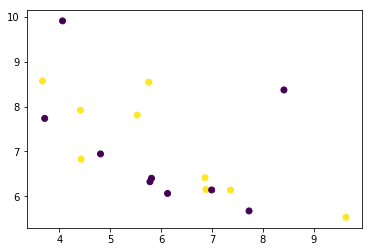

In [1385]:
# support vectors for two different classes
plt.scatter(best_model.supp_vec[:, 0], best_model.supp_vec[:, 1], c=best_model.supp_vec_t);